In [1]:
ENV='local' 
# ENV='colab'

In [2]:
if 'colab' in ENV:
    !sudo apt-get install sox
    !pip install opensmile

In [3]:
import os
from pathlib import Path
import tqdm
import glob

import soundfile as sf
import opensmile
from IPython.display import Audio

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

Funciones para extraccion de features de los archivos de audio:

In [4]:
def get_lld_feats(file_path):
    '''
    Devuelve los atributos de bajo nivel (LLD) de un audio.
    '''
    smile = opensmile.Smile(
        feature_set   = opensmile.FeatureSet.eGeMAPSv02,
        feature_level = opensmile.FeatureLevel.LowLevelDescriptors,
    )
    feats = smile.process_file(file_path, channel=0)
    return feats.reset_index()


def get_functional_feats(file_path):
    '''
    Devuelve los atributos de alto nivel (Functionals) de un audio.
    
    Se calculan a partir de los atributos de bajo nivel, calculando estadísticas 
    que resuman las secuencias. Los modelos que vimos no modelan secuencias!, 
    por ende, es necesario disponer de atributos.
    que consistan de vectores fijos.
    '''
    smile = opensmile.Smile(
        feature_set   = opensmile.FeatureSet.eGeMAPSv02,
        feature_level = opensmile.FeatureLevel.Functionals,
    )
    feats = smile.process_file(file_path, channel=0)
    return feats.reset_index()

def plot_feats(feats):
    feats_cols = [col for col in feats.columns if col not in ['file','start','end']]
    for col in feats_cols:
      plt.figure()
      plt.plot(feats.start.dt.total_seconds(),feats[col].values)
      plt.title(col)

Funciones para escuchar el audio de un ejemplo del dataset:

In [17]:
def play_audio(path, rate=None):
    x, sr = sf.read(path)
    display(Audio(x, rate=sr))
    time = np.arange(0,len(x)) / sr
    plt.plot(time,x)

def play(example):
    play_audio(example.file_path)

### Dataset

In [14]:
def download_audio_speech_actors_dataset(path):
    '''
    Descarga el dataset y los descomprime en el path pasado como parametro.
    '''
    if os.path.exists(path):
        print('Dataset alredy downloaded!')
        return

    print('Download dataset...')
    !wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
    !unzip Audio_Speech_Actors_01-24.zip -d $path
    !rm Audio_Speech_Actors_01-24.zip
    

class Dataset:
    def __init__(self, dataset_path='./ravdess'):
        self.dataset_path = dataset_path
        download_audio_speech_actors_dataset(self.dataset_path)

    def get_all(self, with_feats=True):
        '''
        Usa el metodo de busqueda search_by para consultar todos lo ejemplos del dataset.
        '''
        return self.search_by('Actor_*', '*', with_feats)

    def search_by(self, actor_pattern, filename_pattern, with_feats=True):
        '''
        Permite buscar ejemplos en el dataset buscando con un patro por artista y otro patro 
        para el nombre del archivo. 
        
        Devuelve una tabla donde cada ejemplo tiene como columnas todos los datos extraidos del
        nombre del archivo de audio y ademas todos los atributos extraido del audio con la 
        libreria opensmile.
        ''' 
        search_path = '{}/{}/{}.wav'.format(self.dataset_path, actor_pattern, filename_pattern)
        result_file_paths = glob.glob(search_path)

        examples = []        
        for index in tqdm(range(len(result_file_paths))):
            file_path = result_file_paths[index]

            parts = self.__get_file_parts(file_path)    

            example = {
                'file_path'          : file_path,
                'modality'           : parts[0],
                'vocal_channel'      : parts[1],
                'emotion'            : parts[2],
                'emotional_intensity': parts[3],
                'statement'          : parts[4],
                'repetition'         : parts[5],
                'actor'              : parts[6]
            }
            if with_feats:
                self.__append_feats(example)
            
            examples.append(example)

        return pd.DataFrame(examples)
    
    def __get_file_parts(self, file_path):
        filename       = Path(file_path).stem
        return filename.split('-')
    
    def __append_feats(self, example):
        feats = get_functional_feats(example['file_path'])            
        for feat_col in feats.columns:
            example[feat_col] = feats[feat_col][0]

Creamos el dataset: Este ya se encarga de bajar los datos por unica vez.

In [15]:
dataset = Dataset()

Dataset alredy downloaded!


Le pedimos que nos devuelve todos los ejemplo del dataset:

In [20]:
examples = dataset.get_all()

examples.head()

100%|██████████| 1440/1440 [02:02<00:00, 11.79it/s]


,file_path,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,file,start,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,./ravdess/Actor_23/03-01-04-02-01-01-23.wav,03,01,04,02,01,01,23,./ravdess/Actor_23/03-01-04-02-01-01-23.wav,0 days,...,0.044101,0.007548,0.015374,1.877934,1.425178,0.251667,0.247482,0.367143,0.419309,-39.951572
1,./ravdess/Actor_23/03-01-04-02-02-02-23.wav,03,01,04,02,02,02,23,./ravdess/Actor_23/03-01-04-02-02-02-23.wav,0 days,...,0.011092,0.008020,0.014090,1.694915,0.856531,0.357500,0.072241,0.634000,0.483429,-42.310856
2,./ravdess/Actor_23/03-01-06-02-01-02-23.wav,03,01,06,02,01,02,23,./ravdess/Actor_23/03-01-06-02-01-02-23.wav,0 days,...,0.101003,0.014311,0.014765,2.339181,0.593472,0.635000,0.335000,0.683333,0.449024,-34.312801
3,./ravdess/Actor_23/03-01-07-01-01-02-23.wav,03,01,07,01,01,02,23,./ravdess/Actor_23/03-01-07-01-01-02-23.wav,0 days,...,0.062009,0.011443,0.021647,2.528090,1.424501,0.180000,0.099800,0.416667,0.422834,-44.573288
4,./ravdess/Actor_23/03-01-03-01-01-02-23.wav,03,01,03,01,01,02,23,./ravdess/Actor_23/03-01-03-01-01-02-23.wav,0 days,...,0.032799,0.011666,0.009868,2.153846,0.625000,0.570000,0.320000,0.670000,0.452548,-36.173256


Gardamos los ejemplo por que demora un tiempo generarlos:

In [24]:
examples.to_csv('examples.csv')

In [26]:
exampels = pd.read_csv('examples.csv')

Escuchemos el primer ejemplo de la tabla:

In [27]:
example = exampels.iloc[0, :]

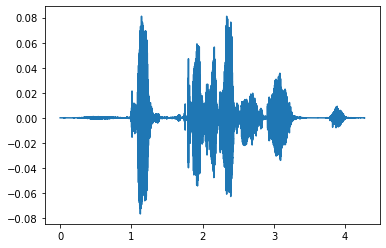

In [28]:
play(example)

Y si quiero los atributos de bajo nivel del audio ?

In [23]:
get_lld_feats(example.file_path)

,file,start,end,Loudness_sma3,alphaRatio_sma3,hammarbergIndex_sma3,slope0-500_sma3,slope500-1500_sma3,spectralFlux_sma3,mfcc1_sma3,...,logRelF0-H1-A3_sma3nz,F1frequency_sma3nz,F1bandwidth_sma3nz,F1amplitudeLogRelF0_sma3nz,F2frequency_sma3nz,F2bandwidth_sma3nz,F2amplitudeLogRelF0_sma3nz,F3frequency_sma3nz,F3bandwidth_sma3nz,F3amplitudeLogRelF0_sma3nz
0,./ravdess/Actor_23/03-01-04-02-01-01-23.wav,0 days 00:00:00,0 days 00:00:00.020000,0.005522,-8.685525,18.717031,-0.004917,0.011423,0.000185,-2.130955,...,0.0,818.257629,866.181946,-201.0,1861.408081,429.928864,-201.0,2906.998047,440.170166,-201.0
1,./ravdess/Actor_23/03-01-04-02-01-01-23.wav,0 days 00:00:00.010000,0 days 00:00:00.030000,0.006507,-9.241057,18.630091,-0.031496,0.011487,0.000274,-2.270647,...,0.0,815.680359,888.674805,-201.0,1889.707642,455.406982,-201.0,2979.269775,479.979980,-201.0
2,./ravdess/Actor_23/03-01-04-02-01-01-23.wav,0 days 00:00:00.020000,0 days 00:00:00.040000,0.007641,-9.963546,20.235626,-0.042630,0.011367,0.000420,-0.848860,...,0.0,848.010193,829.167969,-201.0,1978.086548,521.012146,-201.0,3039.273193,606.114197,-201.0
3,./ravdess/Actor_23/03-01-04-02-01-01-23.wav,0 days 00:00:00.030000,0 days 00:00:00.050000,0.007518,-12.438800,22.748400,-0.060534,0.012382,0.000573,0.172083,...,0.0,1189.738525,773.777588,-201.0,2165.650635,755.215515,-201.0,3286.108154,554.920227,-201.0
4,./ravdess/Actor_23/03-01-04-02-01-01-23.wav,0 days 00:00:00.040000,0 days 00:00:00.060000,0.006846,-14.907390,25.289560,-0.057707,0.013356,0.000699,1.726671,...,0.0,1245.904663,667.544312,-201.0,2212.144043,646.857056,-201.0,3324.741211,613.032410,-201.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,./ravdess/Actor_23/03-01-04-02-01-01-23.wav,0 days 00:00:04.180000,0 days 00:00:04.200000,0.007059,0.457714,6.589346,0.068463,0.009636,0.000218,-2.822469,...,0.0,547.951172,1022.589417,-201.0,1449.198242,915.341614,-201.0,2497.744629,476.660767,-201.0
419,./ravdess/Actor_23/03-01-04-02-01-01-23.wav,0 days 00:00:04.190000,0 days 00:00:04.210000,0.006997,0.672959,6.824489,0.063756,0.010725,0.000206,-3.352999,...,0.0,563.062317,834.282410,-201.0,1558.112305,932.673340,-201.0,2396.144775,355.636932,-201.0
420,./ravdess/Actor_23/03-01-04-02-01-01-23.wav,0 days 00:00:04.200000,0 days 00:00:04.220000,0.007747,1.257103,5.917667,0.039852,0.013881,0.000207,-3.232772,...,0.0,605.910767,708.455322,-201.0,1638.209595,1082.508179,-201.0,2345.018799,283.528778,-201.0
421,./ravdess/Actor_23/03-01-04-02-01-01-23.wav,0 days 00:00:04.210000,0 days 00:00:04.230000,0.007861,0.944033,4.721296,0.044277,0.013434,0.000199,-2.207005,...,0.0,603.738037,566.000305,-201.0,1767.541626,1127.024292,-201.0,2335.895752,247.008469,-201.0
